In [1]:
%load_ext memory_profiler

import numpy as np

import scipy
import scipy.sparse as sparse
import scipy.io as io

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from openTSNE import TSNE

import scanpy as sc

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.metrics import f1_score, silhouette_score, silhouette_samples

#import statsmodels.api as sm

# Load data

In [2]:
mtx = io.mmread('../datasets/zhengmix8eq/mat.mtx').astype(np.float32).tocsc()
meta = pd.read_csv('../datasets/zhengmix8eq/meta.csv', index_col=0)

# FastRNA

In [3]:
from fastrna.mkl_funcs import *
from fastrna.utils import *
from fastrna.core import fastrna_hvg, fastrna_pca

In [4]:
%time gene_vars = fastrna_hvg(mtx, np.zeros(mtx.shape[1])) # add memit to see memory
gene_order_var = gene_vars.argsort()[::-1]
mtx_hvg = mtx[gene_order_var[:2000],:] 
mtx_hvg.sort_indices()
numi = np.asarray(mtx.sum(axis=0)).ravel()
%time eig_val, eig_vec, pca, rrt = fastrna_pca(mtx_hvg, numi, np.zeros(mtx.shape[1])) # add %memit to see memory
pd.DataFrame(pca).to_csv('pca_coord/zhengmix8eq/pca_fr.csv')

CPU times: user 438 ms, sys: 29.4 ms, total: 468 ms
Wall time: 49.6 ms
CPU times: user 4.37 s, sys: 220 ms, total: 4.59 s
Wall time: 191 ms


# Scanpy

In [5]:
adata = sc.AnnData(mtx.T)
%time %memit sc.experimental.pp.highly_variable_genes(adata, flavor="pearson_residuals", n_top_genes=2000)
adata_fs = adata[:, adata.var["highly_variable"]]
%time sc.experimental.pp.normalize_pearson_residuals(adata_fs)
%time sc.pp.pca(adata_fs, n_comps=50)
pd.DataFrame(adata_fs.obsm['X_pca']).to_csv('pca_coord/zhengmix8eq/pca_ap.csv')

peak memory: 468.21 MiB, increment: 98.99 MiB
CPU times: user 861 ms, sys: 297 ms, total: 1.16 s
Wall time: 1.26 s
CPU times: user 97.9 ms, sys: 36.7 ms, total: 135 ms
Wall time: 135 ms


/home/hanbin973/anaconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/experimental/pp/_normalization.py:123: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


CPU times: user 17.6 s, sys: 11 s, total: 28.7 s
Wall time: 631 ms


# Benchmark - Dim reduction
Run after the corresponding R codes are finished.

In [6]:
name = 'zhengmix8eq'
pca_logpca = pd.read_csv('../fastrna_r/pca_coord/%s/pca_log.csv' % name, index_col=0).values
pca_sct = pd.read_csv('../fastrna_r/pca_coord/%s/pca_sct.csv' % name, index_col=0).values
pca_glmpca = pd.read_csv('../fastrna_r/pca_coord/%s/pca_glmpca.csv' % name, index_col=0).values
pca_ap = pd.read_csv('pca_coord/%s/pca_ap.csv' % name, index_col=0).values
pca_fr = pd.read_csv('pca_coord/%s/pca_fr.csv' % name, index_col=0).values

In [7]:
sils = []
Xs = [pca_logpca[:,:30], pca_sct[:,:30], pca_glmpca[:,:30], pca_ap[:,:30], pca_fr[:,:30]]
labels = [meta['phenoid'].values] * len(Xs)

for X, lab in zip(Xs, labels):
    sils.append(silhouette_samples(X, lab, metric='cosine'))
sils

[array([ 0.74495453,  0.73437823,  0.71769471, ..., -0.32977382,
         0.38013296,  0.33671567]),
 array([ 0.87464112,  0.87780854,  0.89291836, ..., -0.43402973,
         0.54286187,  0.4164351 ]),
 array([ 0.81751848,  0.77062613,  0.85055423, ..., -0.67321786,
         0.18859149,  0.17297882]),
 array([ 0.85757014,  0.75865855,  0.8257978 , ..., -0.63097812,
         0.52227484,  0.30031532]),
 array([ 0.88589499,  0.7704026 ,  0.86573071, ..., -0.6488577 ,
         0.52621059,  0.19042229])]

In [8]:
scores =[]
for X, lab in zip(Xs, labels):
    labels = pd.factorize(lab)[0]
    k=5
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, labels, cv=5, scoring='accuracy')
    scores.append(score)
    
scores

[array([0.76720901, 0.76095119, 0.77221527, 0.75969962, 0.78195489]),
 array([0.82227785, 0.81727159, 0.81226533, 0.80600751, 0.81328321]),
 array([0.87609512, 0.88110138, 0.86483104, 0.85607009, 0.87343358]),
 array([0.8097622 , 0.81727159, 0.8310388 , 0.81727159, 0.83082707]),
 array([0.80225282, 0.80100125, 0.82853567, 0.79599499, 0.82205514])]

In [9]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial"

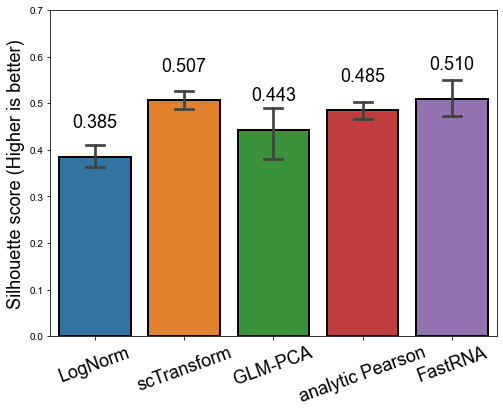

In [10]:
df = pd.DataFrame(np.array(sils).T, columns=['LogNorm', 
                                               'scTransform',
                                               'GLM-PCA',
                                               'analytic Pearson',
                                               'FastRNA'])
df_melt = pd.melt(df, var_name='Method', value_name='Silhouette score')        

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x='Method', y='Silhouette score', data=df_melt, ax=ax,
           edgecolor='black', linewidth=2, capsize=.2, estimator=np.median)

ax.set_xlabel(ax.get_xlabel(), fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18, rotation=20)

ax.set_ylabel(ax.get_ylabel() + ' (Higher is better)', fontsize=18)

ax.bar_label(ax.containers[0], fontsize=18, padding=25, fmt='%.3f')
ax.set_ylim([0,0.7])
ax.set_title('', fontsize=18, va='bottom')
ax.set_xlabel('')

plt.show()

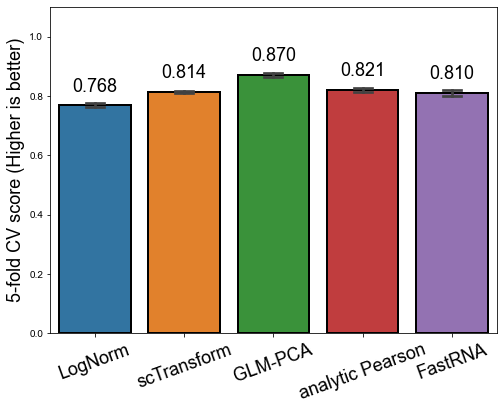

In [11]:
df = pd.DataFrame(np.array(scores).T, columns=['LogNorm', 
                                               'scTransform',
                                               'GLM-PCA',
                                               'analytic Pearson',
                                               'FastRNA'])
df_melt = pd.melt(df, var_name='Method', value_name='5-fold CV score')        

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x='Method', y='5-fold CV score', data=df_melt, ax=ax,
           edgecolor='black', linewidth=2, capsize=.2)

ax.set_xlabel(ax.get_xlabel(), fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18, rotation=20)

ax.set_ylabel(ax.get_ylabel() + ' (Higher is better)', fontsize=18)

ax.bar_label(ax.containers[0], fontsize=18, padding=10, fmt='%.3f')
ax.set_ylim([0,1.1])
ax.set_title('', fontsize=18, va='bottom')
ax.set_xlabel('')

plt.show()

# t-SNE

In [12]:
name = 'zhengmix8eq'
pca_logpca = pd.read_csv('../fastrna_r/pca_coord/%s/pca_log.csv' % name, index_col=0).values
pca_sct = pd.read_csv('../fastrna_r/pca_coord/%s/pca_sct.csv' % name, index_col=0).values
#pca_harmony = pd.read_csv('../fastrna_r/pca_coord/%s/pca_harmony.csv' % name, index_col=0).values
pca_glmpca = pd.read_csv('../fastrna_r/pca_coord/%s/pca_glmpca.csv' % name, index_col=0).values
pca_ap = pd.read_csv('pca_coord/%s/pca_ap.csv' % name, index_col=0).values
pca_fr = pd.read_csv('pca_coord/%s/pca_fr.csv' % name, index_col=0).values

In [13]:
def dotsne(pca):
    tsne = TSNE(n_jobs=16, perplexity=30, exaggeration=2, initialization=pca[:,:2]).fit(pca[:,:30])
    return tsne

tsne_logpca = dotsne(pca_logpca)
tsne_sct = dotsne(pca_sct)
tsne_glmpca = dotsne(pca_glmpca)
tsne_ap = dotsne(pca_ap)
tsne_fr = dotsne(pca_fr)

Standard deviation of embedding is greater than 0.0001. Initial embeddings with high variance may have display poor convergence.
Standard deviation of embedding is greater than 0.0001. Initial embeddings with high variance may have display poor convergence.
Standard deviation of embedding is greater than 0.0001. Initial embeddings with high variance may have display poor convergence.
Standard deviation of embedding is greater than 0.0001. Initial embeddings with high variance may have display poor convergence.
Standard deviation of embedding is greater than 0.0001. Initial embeddings with high variance may have display poor convergence.


In [14]:
ct_reorder = meta.phenoid.values

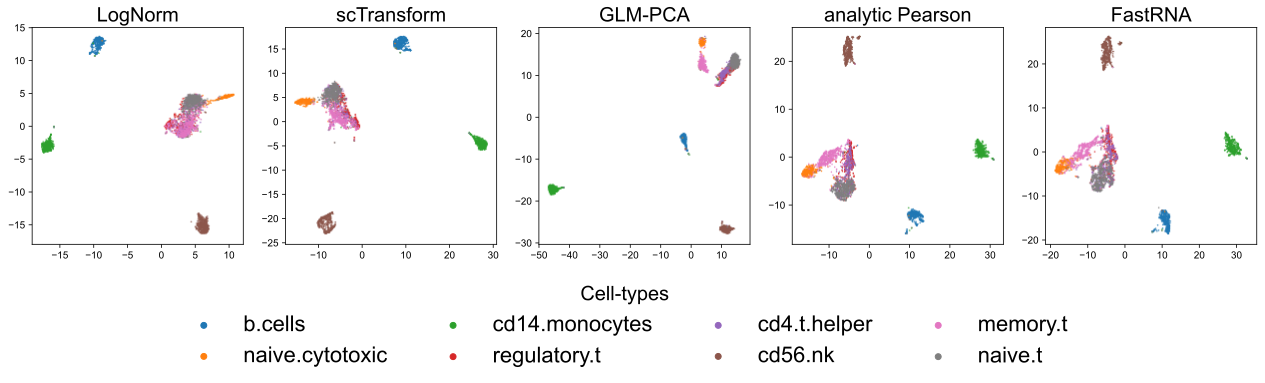

In [15]:
%config InlineBackend.figure_formats = ['svg']
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial"

fig, ax = plt.subplots(1, 5, figsize=(22, 4))
np.random.seed(0)

scatter = sns.scatterplot(x=tsne_logpca[:,0], y=tsne_logpca[:,1], 
                s=2, 
                hue=ct_reorder, 
                edgecolor='none', 
                legend=True,
                ax=ax[0],
                palette='tab10',  rasterized=True
                )

sns.scatterplot(x=tsne_sct[:,0], y=tsne_sct[:,1], 
                s=2, 
                hue=ct_reorder, 
                edgecolor='none', 
                legend=False,
                ax=ax[1],
                palette='tab10',  rasterized=True
                )

sns.scatterplot(x=tsne_glmpca[:,0], y=tsne_glmpca[:,1], 
                s=2, 
                hue=ct_reorder, 
                edgecolor='none', 
                legend=False,
                ax=ax[2],
                palette='tab10',  rasterized=True
                )

sns.scatterplot(x=tsne_ap[:,0], y=tsne_ap[:,1], 
                s=2, 
                hue=ct_reorder, 
                edgecolor='none', 
                legend=False,
                ax=ax[3],
                palette='tab10',  rasterized=True
                )

sns.scatterplot(x=tsne_fr[:,0], y=tsne_fr[:,1], 
                s=2, 
                hue=ct_reorder, 
                edgecolor='none', 
                legend=False,
                ax=ax[4],
                palette='tab10',  rasterized=True
                )

ax[0].legend().set_visible(False)

handles0, labels0 = ax[0].get_legend_handles_labels()
legend = fig.legend(handles0, 
           labels0, 
           bbox_to_anchor=(0.5,0.05), 
           loc='upper center', 
           ncol=4, 
           fontsize=22,
           frameon=False)

legend.set_title('Cell-types', prop={'size':20})

labels = ['LogNorm', 'scTransform', 'GLM-PCA', 'analytic Pearson', 'FastRNA']
for _ax, _label in zip(ax, labels):
    _ax.set_title(_label, fontsize=20)

plt.show()